## **ПРАКТИЧЕСКОЕ ЗАДАНИЕ**

Данные берем отызывы за лето.

На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

In [ ]:
# импортируем библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install xlrd==1.2.0
!pip install pymorphy2
!pip install stop_words
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, Masking, LSTM, GRU
from keras.layers import Embedding, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping  
from keras.utils import np_utils

In [61]:
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, Masking, LSTM, GRU

In [2]:
# вспомогательные функции

# функция обработки текста
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub('\sне', 'не', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)


# функция преобразования текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

#### **ПРЕДОБРАБОТКА ДАННЫХ**

In [4]:
# загрузим отзывы

data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/NLP/отзывы за лето.xls')
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [5]:
# обработаем отзывы

exclude = set(punctuation)
sw = set(get_stop_words('ru'))
morpher = MorphAnalyzer()

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = (data['Rating'] > 3)*1

In [6]:
data['target'] = data['target'].astype(int)
data.head()

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...,1
2,5,Отлично все,2017-08-14,отлично всё,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать на 1 работа антивирус далёкий н...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,1


In [7]:
# разделим тексты на трейн и тест выборки

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=13, stratify=data['target'])

In [8]:
X_train.head()

547                                              классно
1863       невозможно использовать на рутованный телефон
13949                      работать хорошо без нарекание
11501                                            отлично
6238     ян мочь понять почему заблокировать мой аккаунт
Name: text, dtype: object

#### **СОЗДАНИЕ ТОКЕНОВ И ИХ ВЕКТОРИЗАЦИЯ**

In [9]:
# соберем отзывы в один текст и создадим токены

train_corpus = ' '.join(X_train)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)

In [10]:
# отфильтруем цифро-буквенные токены

tokens_filtered = [word for word in tokens if word.isalnum()]

In [11]:
# зададим необходимые параметры, чтобы подготовить токены для работы с нейронной сетью

MAX_WORDS = 300
MAX_LEN = 100
NUM_CLASSES = 2

In [12]:
# создадим словарь с частотой употребления токенов
dist = FreqDist(tokens_filtered)

# возьмем топ самых частых токенов
tokens_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS-1)]
tokens_filtered_top[:10]

['приложение',
 'всё',
 'и',
 'очень',
 'удобно',
 'в',
 'я',
 'на',
 'работать',
 'удобный']

In [13]:
# создадим словарь для обучения

vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [14]:
# конвертируем текст в последовательность

X_train_arr = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_train], dtype=np.int32)
X_test_arr = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_test], dtype=np.int32)

In [92]:
X_train

547                                              классно
1863       невозможно использовать на рутованный телефон
13949                      работать хорошо без нарекание
11501                                            отлично
6238     ян мочь понять почему заблокировать мой аккаунт
                              ...                       
5897                                        спсиб за всё
19812                                              супер
14734                                             удобно
4851                                               супер
19238                                         всё хорошо
Name: text, Length: 15798, dtype: object

In [15]:
X_train_arr.shape

(15798, 100)

In [16]:
X_train_arr[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 298,  23,
       121,  67,  93,  28, 299,  31,  18,   2,  70], dtype=int32)

In [17]:
# преобразуем таргет

y_train_c = keras.utils.np_utils.to_categorical(y_train, NUM_CLASSES)
y_test_c = keras.utils.np_utils.to_categorical(y_test, NUM_CLASSES)

#### **ОБУЧЕНИЕ CNN С НАТРЕНИРОВАННЫМИ ВЕСАМИ**

Модель: ruwikiruscorpora_upos_cbow_300_10_2021

https://rusvectores.org/ru/models/

In [18]:
# скачаем модель с преобученными весами
# ruwikiruscorpora_upos_cbow_300_10_2021

!wget http://vectors.nlpl.eu/repository/20/220.zip
!unzip /content/220.zip

--2022-09-11 18:07:32--  http://vectors.nlpl.eu/repository/20/220.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638171816 (609M) [application/zip]
Saving to: ‘220.zip’

220.zip             100%[===================>] 608.61M  24.6MB/s    in 26s     

2022-09-11 18:07:58 (23.7 MB/s) - ‘220.zip’ saved [638171816/638171816]

Archive:  /content/220.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [108]:
# Создадим словарь из токенов и их предобученных весов

embeddings_index = {}
with open('/content/model.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 249334 word vectors.


In [109]:
# зададим необходимые параметры для работы с нейронной сетью

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 256
PRINT_BATCH_N = 100

In [110]:
# вычислим матрицу векторов

embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [111]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_cnn_pretrained = model.fit(X_train_arr, y_train_c,
                                   batch_size=BATCH_SIZE,
                                   epochs=EPOCHS,
                                   verbose=1,
                                   validation_data=(X_test_arr, y_test_c),
                                   # callbacks=[tensorboard, early_stopping]
                                   )

Epoch 1/10
62/62 [==============================] - 10s 152ms/step - loss: 0.6727 - accuracy: 0.8361 - val_loss: 0.6524 - val_accuracy: 0.8468
Epoch 2/10
62/62 [==============================] - 9s 149ms/step - loss: 0.6346 - accuracy: 0.8469 - val_loss: 0.6170 - val_accuracy: 0.8468
Epoch 3/10
62/62 [==============================] - 9s 149ms/step - loss: 0.6018 - accuracy: 0.8469 - val_loss: 0.5867 - val_accuracy: 0.8468
Epoch 4/10
62/62 [==============================] - 9s 149ms/step - loss: 0.5737 - accuracy: 0.8469 - val_loss: 0.5607 - val_accuracy: 0.8468
Epoch 5/10
62/62 [==============================] - 10s 166ms/step - loss: 0.5496 - accuracy: 0.8469 - val_loss: 0.5385 - val_accuracy: 0.8468
Epoch 6/10
62/62 [==============================] - 10s 164ms/step - loss: 0.5290 - accuracy: 0.8469 - val_loss: 0.5197 - val_accuracy: 0.8468
Epoch 7/10
62/62 [==============================] - 10s 154ms/step - loss: 0.5116 - accuracy: 0.8469 - val_loss: 0.5038 - val_accuracy: 0.8468
Ep

#### **ОБУЧЕНИЕ CNN БЕЗ НАТРЕНИРОВАННЫХ ВЕСОВ**

In [112]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_cnn = model.fit(X_train_arr, y_train_c,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(X_test_arr, y_test_c),
                        # callbacks=[tensorboard, early_stopping]
                        )

Epoch 1/10
62/62 [==============================] - 13s 201ms/step - loss: 0.3987 - accuracy: 0.8438 - val_loss: 0.2110 - val_accuracy: 0.9038
Epoch 2/10
62/62 [==============================] - 12s 200ms/step - loss: 0.2059 - accuracy: 0.9116 - val_loss: 0.1818 - val_accuracy: 0.9159
Epoch 3/10
62/62 [==============================] - 12s 199ms/step - loss: 0.1868 - accuracy: 0.9247 - val_loss: 0.1809 - val_accuracy: 0.9197
Epoch 4/10
62/62 [==============================] - 12s 200ms/step - loss: 0.1787 - accuracy: 0.9295 - val_loss: 0.1804 - val_accuracy: 0.9180
Epoch 5/10
62/62 [==============================] - 12s 198ms/step - loss: 0.1731 - accuracy: 0.9311 - val_loss: 0.1858 - val_accuracy: 0.9205
Epoch 6/10
62/62 [==============================] - 12s 199ms/step - loss: 0.1631 - accuracy: 0.9344 - val_loss: 0.1857 - val_accuracy: 0.9225
Epoch 7/10
62/62 [==============================] - 12s 200ms/step - loss: 0.1578 - accuracy: 0.9389 - val_loss: 0.1927 - val_accuracy: 0.9223

#### **ОБУЧЕНИЕ RNN**

In [113]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(SimpleRNN(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_rnn = model.fit(X_train_arr, y_train_c,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(X_test_arr, y_test_c),
                        # callbacks=[tensorboard, early_stopping]
                        )

Epoch 1/10
62/62 [==============================] - 14s 202ms/step - loss: 0.4428 - accuracy: 0.7983 - val_loss: 0.3158 - val_accuracy: 0.8747
Epoch 2/10
62/62 [==============================] - 12s 201ms/step - loss: 0.2669 - accuracy: 0.8887 - val_loss: 0.2148 - val_accuracy: 0.9028
Epoch 3/10
62/62 [==============================] - 12s 200ms/step - loss: 0.2240 - accuracy: 0.9083 - val_loss: 0.2430 - val_accuracy: 0.9091
Epoch 4/10
62/62 [==============================] - 12s 199ms/step - loss: 0.2163 - accuracy: 0.9088 - val_loss: 0.2019 - val_accuracy: 0.9134
Epoch 5/10
62/62 [==============================] - 13s 204ms/step - loss: 0.2108 - accuracy: 0.9122 - val_loss: 0.1953 - val_accuracy: 0.9167
Epoch 6/10
62/62 [==============================] - 12s 199ms/step - loss: 0.2063 - accuracy: 0.9158 - val_loss: 0.2022 - val_accuracy: 0.9154
Epoch 7/10
62/62 [==============================] - 12s 199ms/step - loss: 0.1996 - accuracy: 0.9166 - val_loss: 0.2500 - val_accuracy: 0.9084

#### **ОБУЧЕНИЕ LSTM**

In [114]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_lstm = model.fit(X_train_arr, y_train_c,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         verbose=1,
                         validation_data=(X_test_arr, y_test_c),
                         # callbacks=[tensorboard, early_stopping]
                         )

Epoch 1/10
62/62 [==============================] - 34s 504ms/step - loss: 0.3865 - accuracy: 0.8464 - val_loss: 0.2377 - val_accuracy: 0.8977
Epoch 2/10
62/62 [==============================] - 31s 500ms/step - loss: 0.2273 - accuracy: 0.9083 - val_loss: 0.1994 - val_accuracy: 0.9137
Epoch 3/10
62/62 [==============================] - 31s 500ms/step - loss: 0.1976 - accuracy: 0.9214 - val_loss: 0.1975 - val_accuracy: 0.9203
Epoch 4/10
62/62 [==============================] - 31s 499ms/step - loss: 0.1917 - accuracy: 0.9237 - val_loss: 0.1907 - val_accuracy: 0.9215
Epoch 5/10
62/62 [==============================] - 31s 499ms/step - loss: 0.1860 - accuracy: 0.9247 - val_loss: 0.1891 - val_accuracy: 0.9225
Epoch 6/10
62/62 [==============================] - 31s 499ms/step - loss: 0.1808 - accuracy: 0.9249 - val_loss: 0.1894 - val_accuracy: 0.9195
Epoch 7/10
62/62 [==============================] - 31s 502ms/step - loss: 0.1772 - accuracy: 0.9276 - val_loss: 0.2004 - val_accuracy: 0.9154

#### **ОБУЧЕНИЕ GRU**

In [115]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_gru = model.fit(X_train_arr, y_train_c,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(X_test_arr, y_test_c),
                        # callbacks=[tensorboard, early_stopping]
                        )

Epoch 1/10
62/62 [==============================] - 35s 510ms/step - loss: 0.3632 - accuracy: 0.8591 - val_loss: 0.2345 - val_accuracy: 0.8949
Epoch 2/10
62/62 [==============================] - 31s 504ms/step - loss: 0.2214 - accuracy: 0.9073 - val_loss: 0.1913 - val_accuracy: 0.9175
Epoch 3/10
62/62 [==============================] - 31s 505ms/step - loss: 0.1944 - accuracy: 0.9202 - val_loss: 0.1886 - val_accuracy: 0.9192
Epoch 4/10
62/62 [==============================] - 31s 505ms/step - loss: 0.1863 - accuracy: 0.9239 - val_loss: 0.1911 - val_accuracy: 0.9215
Epoch 5/10
62/62 [==============================] - 31s 504ms/step - loss: 0.1856 - accuracy: 0.9249 - val_loss: 0.1907 - val_accuracy: 0.9208
Epoch 6/10
62/62 [==============================] - 31s 502ms/step - loss: 0.1808 - accuracy: 0.9270 - val_loss: 0.1881 - val_accuracy: 0.9225
Epoch 7/10
62/62 [==============================] - 31s 502ms/step - loss: 0.1749 - accuracy: 0.9278 - val_loss: 0.1835 - val_accuracy: 0.9197

#### **ОБУЧЕНИЕ CNN+RNN**

In [116]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
# model.add(GlobalMaxPool1D())
model.add(SimpleRNN(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_cnn_rnn = model.fit(X_train_arr, y_train_c,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=1,
                            validation_data=(X_test_arr, y_test_c),
                            # callbacks=[tensorboard, early_stopping]
                            )

Epoch 1/10
62/62 [==============================] - 22s 326ms/step - loss: 0.4321 - accuracy: 0.8032 - val_loss: 0.2900 - val_accuracy: 0.8765
Epoch 2/10
62/62 [==============================] - 20s 320ms/step - loss: 0.2688 - accuracy: 0.8902 - val_loss: 0.2101 - val_accuracy: 0.9089
Epoch 3/10
62/62 [==============================] - 20s 319ms/step - loss: 0.2210 - accuracy: 0.9109 - val_loss: 0.2017 - val_accuracy: 0.9132
Epoch 4/10
62/62 [==============================] - 20s 319ms/step - loss: 0.2058 - accuracy: 0.9154 - val_loss: 0.2158 - val_accuracy: 0.9109
Epoch 5/10
62/62 [==============================] - 20s 320ms/step - loss: 0.1969 - accuracy: 0.9178 - val_loss: 0.1889 - val_accuracy: 0.9180
Epoch 6/10
62/62 [==============================] - 20s 319ms/step - loss: 0.1918 - accuracy: 0.9216 - val_loss: 0.1970 - val_accuracy: 0.9162
Epoch 7/10
62/62 [==============================] - 20s 319ms/step - loss: 0.1853 - accuracy: 0.9232 - val_loss: 0.1894 - val_accuracy: 0.9172

#### **ОБУЧЕНИЕ CNN+LSTM**

In [170]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
# model.add(GlobalMaxPool1D())
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_cnn_lstm = model.fit(X_train_arr, y_train_c,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             verbose=1,
                             validation_data=(X_test_arr, y_test_c),
                             # callbacks=[tensorboard, early_stopping]
                             )

Epoch 1/10
62/62 [==============================] - 52s 803ms/step - loss: 0.3469 - accuracy: 0.8637 - val_loss: 0.2209 - val_accuracy: 0.9033
Epoch 2/10
62/62 [==============================] - 48s 760ms/step - loss: 0.2118 - accuracy: 0.9141 - val_loss: 0.2017 - val_accuracy: 0.9144
Epoch 3/10
62/62 [==============================] - 39s 620ms/step - loss: 0.1881 - accuracy: 0.9234 - val_loss: 0.1883 - val_accuracy: 0.9203
Epoch 4/10
62/62 [==============================] - 38s 622ms/step - loss: 0.1822 - accuracy: 0.9256 - val_loss: 0.1906 - val_accuracy: 0.9218
Epoch 5/10
62/62 [==============================] - 40s 648ms/step - loss: 0.1752 - accuracy: 0.9270 - val_loss: 0.1820 - val_accuracy: 0.9190
Epoch 6/10
62/62 [==============================] - 47s 746ms/step - loss: 0.1692 - accuracy: 0.9282 - val_loss: 0.1826 - val_accuracy: 0.9192
Epoch 7/10
62/62 [==============================] - 38s 620ms/step - loss: 0.1668 - accuracy: 0.9292 - val_loss: 0.1904 - val_accuracy: 0.9159

#### **ОБУЧЕНИЕ CNN+GRU**

In [118]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
# model.add(GlobalMaxPool1D())
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


model.summary()


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_cnn_gru = model.fit(X_train_arr, y_train_c,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=1,
                            validation_data=(X_test_arr, y_test_c),
                            # callbacks=[tensorboard, early_stopping]
                            )

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 100, 128)          38400     
                                                                 
 masking_30 (Masking)        (None, 100, 128)          0         
                                                                 
 conv1d_28 (Conv1D)          (None, 98, 128)           49280     
                                                                 
 activation_83 (Activation)  (None, 98, 128)           0         
                                                                 
 gru_19 (GRU)                (None, 64)                37248     
                                                                 
 dense_56 (Dense)            (None, 32)                2080      
                                                                 
 activation_84 (Activation)  (None, 32)              

#### **ОБУЧЕНИЕ GRU+CNN**

In [119]:
# построим архитектуру сети

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2, return_sequences=True))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# скомпилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# проведем обучение модели

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history_gru_cnn = model.fit(X_train_arr, y_train_c,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=1,
                            validation_data=(X_test_arr, y_test_c),
                            # callbacks=[tensorboard, early_stopping]
                            )

Epoch 1/10
62/62 [==============================] - 37s 546ms/step - loss: 0.4291 - accuracy: 0.8421 - val_loss: 0.2325 - val_accuracy: 0.8934
Epoch 2/10
62/62 [==============================] - 33s 537ms/step - loss: 0.2221 - accuracy: 0.9059 - val_loss: 0.1871 - val_accuracy: 0.9132
Epoch 3/10
62/62 [==============================] - 33s 540ms/step - loss: 0.1913 - accuracy: 0.9187 - val_loss: 0.1843 - val_accuracy: 0.9182
Epoch 4/10
62/62 [==============================] - 34s 541ms/step - loss: 0.1845 - accuracy: 0.9215 - val_loss: 0.1854 - val_accuracy: 0.9192
Epoch 5/10
62/62 [==============================] - 34s 543ms/step - loss: 0.1789 - accuracy: 0.9233 - val_loss: 0.1827 - val_accuracy: 0.9203
Epoch 6/10
62/62 [==============================] - 34s 544ms/step - loss: 0.1771 - accuracy: 0.9242 - val_loss: 0.1867 - val_accuracy: 0.9203
Epoch 7/10
62/62 [==============================] - 34s 541ms/step - loss: 0.1770 - accuracy: 0.9264 - val_loss: 0.1848 - val_accuracy: 0.9172

In [173]:
# сделаем сравнительную таблицу по точности на тесте у разных моделей

model_list = [history_cnn_pretrained,
              history_cnn,
              history_rnn,
              history_lstm,
              history_gru,
              history_cnn_rnn,
              history_cnn_lstm,
              history_cnn_gru,
              history_gru_cnn]

model_name_list = ['history_cnn_pretrained',
                   'history_cnn',
                   'history_rnn',
                   'history_lstm',
                   'history_gru',
                   'history_cnn_rnn',
                   'history_cnn_lstm',
                   'history_cnn_gru',
                   'history_gru_cnn']


compare_table = pd.DataFrame()
for item in range(len(model_list)):
  compare_table[model_name_list[item]] = model_list[item].history['val_accuracy']

compare_table

,history_cnn_pretrained,history_cnn,history_rnn,history_lstm,history_gru,history_cnn_rnn,history_cnn_lstm,history_cnn_gru,history_gru_cnn
0,0.846835,0.903797,0.874684,0.897722,0.894937,0.876456,0.903291,0.888608,0.893418
1,0.846835,0.915949,0.902785,0.913671,0.917468,0.908861,0.914430,0.912911,0.913165
2,0.846835,0.919747,0.909114,0.920253,0.919241,0.913165,0.920253,0.921013,0.918228
3,0.846835,0.917975,0.913418,0.921519,0.921519,0.910886,0.921772,0.920506,0.919241
4,0.846835,0.920506,0.916709,0.922532,0.920759,0.917975,0.918987,0.917468,0.920253
5,0.846835,0.922532,0.915443,0.919494,0.922532,0.916203,0.919241,0.914684,0.920253
6,0.846835,0.922278,0.908354,0.915443,0.919747,0.917215,0.915949,0.911139,0.917215
7,0.846835,0.917975,0.916456,0.919494,0.921519,0.915443,0.914937,0.909620,0.918481
8,0.846835,0.922278,0.913671,0.917468,0.921013,0.916456,0.918987,0.914177,0.918987
9,0.846835,0.915696,0.917722,0.916203,0.919747,0.917975,0.917215,0.913671,0.912405


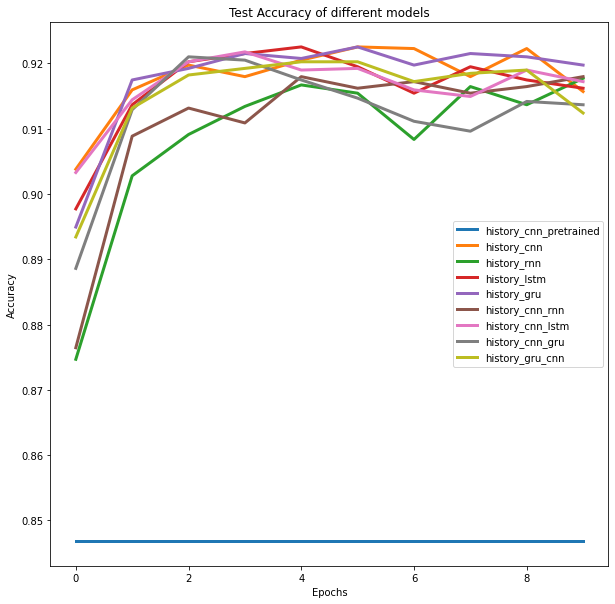

In [177]:
# визуализируем данные сравнительной таблицы

plt.figure(figsize=(10, 10))
for item in range(len(model_list)):
  plt.plot(range(compare_table.shape[0]), compare_table[model_name_list[item]], label=model_name_list[item], linewidth=3)
  plt.legend()
  plt.title('Test Accuracy of different models')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
plt.show()

### **ВЫВОД:**

Наибольшую точность на тестовой выборке показали модели CNN, LSTM и GRU, ~ $0.92$. При этом модель LSTM быстрее всех достигла такой точности. Совмещенные модели (свертка + реккурентный слой и наоборот) не смогли превысить данное значение. Хуже всех обучалась простая RNN.

In [120]:
# score = model.evaluate(X_test_arr, y_test_c, batch_size=BATCH_SIZE, verbose=1)
# print('\n')
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# results = model.predict(X_test_arr, batch_size=BATCH_SIZE, verbose=1)